In [1]:
import json 
import pandas as pd
with open('producthunt_posts_2019-01-01_to_2025-01-01.json') as f:
    data = json.load(f)
    

df = pd.DataFrame(data['posts'])

# Read in data

In [119]:
print(df.columns)
# Index(['id', 'name', 'slug', 'tagline', 'description', 'url', 'website',
#        'votesCount', 'commentsCount', 'createdAt', 'featuredAt'],
#       dtype='object')

import re
def string_contains_word(s, word_list):
    """
    Checks if any word from the word_list is present in the string s using regex.

    Args:
        s (str): The input string to search.
        word_list (list): A list of words to search for in the string.

    Returns:
        bool: True if any word from the word_list is found in s, False otherwise.
    """
    # Create a regex pattern to match any word in the word_list
    pattern = r'\b(' + '|'.join(map(re.escape, word_list)) + r')\b'
    return bool(re.search(pattern, s))    
    
ai_terms = ["artificial intelligence", "large language model", "chatbot", "gpt", "a.i.", "chatgpt"]
social_words = [
    "therapist", "coach", "teacher", "scout", "advice", "support",
    "mentor", "counselor", "guide", "trainer", "advisor", "consultant",
    "helper", "facilitator", "mediator", "tutor", "educator", "leader",
    "motivator", "instructor", "advocate", "listener", "companion",
    "partner", "collaborator", "peer", "ally", "friend", "team",
    "network", "community", "group", "interaction", "relationship",
    "communicator", "organizer", "planner", "strategist", "negotiator",
    "influencer", "volunteer", "coordinator", "supervisor", "manager",
    "advisor", "role model", "inspiration", "caretaker", "mediator",
    "psychologist", "psychiatrist", "social worker", "life coach",
    "motivational speaker", "team player", "collaborator", "partner",
    "engager", "connector", "facilitator", "leader", "mediator",
    "advisor", "consultant", "helper", "listener", "supporter"
]
df['text'] = df['name'] + df["tagline"] + df["description"]
df = df.dropna(subset=['text'])
df['text'] = df['text'].apply(lambda x: x.lower())

df['ai'] = df['text'].apply(lambda x: string_contains_word(x, ai_terms))
df['social'] = df['text'].apply(lambda x: string_contains_word(x, social_words))



Index(['id', 'name', 'slug', 'tagline', 'description', 'url', 'website',
       'votesCount', 'commentsCount', 'createdAt', 'featuredAt', 'text', 'ai',
       'social', 'y', 'yhat', 'agreed', 'dt'],
      dtype='object')


# Filter dataframe and create col

In [120]:
df = df.query("ai == True")
df['y'] = df['social'].astype(int)
df['dt'] = pd.to_datetime(df['createdAt'])
df = df.loc[df['dt'] < '2025-01-01']

In [121]:
df['y'].mean()

np.float64(0.17997644287396938)

# ML

In [122]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
import joblib
import numpy as np

# Define the pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('model', LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'))
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['y'], test_size=0.2, random_state=42)

# Perform GridSearchCV
param_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],  # Unigrams and bigrams
    'model__C': [0.01, 0.1, 1, 10]          # Regularization strength
}
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters and model
print("Best Parameters:", grid_search.best_params_)
best_pipeline = grid_search.best_estimator_

# Evaluate the best pipeline
y_pred = best_pipeline.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Save the best pipeline
joblib.dump(best_pipeline, 'text_classification_pipeline.pkl')

# Load the pipeline
loaded_pipeline = joblib.load('text_classification_pipeline.pkl')

# Predict on new data
new_texts = [
    "AI-powered chatbot for customer support.",
    "A mental health coach to help you achieve your goals."
]
predictions = loaded_pipeline.predict(new_texts)
print("Predictions:", predictions)

# Extract and print the most important words
vectorizer = loaded_pipeline.named_steps['tfidf']
model = loaded_pipeline.named_steps['model']
feature_names = np.array(vectorizer.get_feature_names_out())
coefficients = model.coef_.flatten()

# Get top 10 positive and negative words
top_positive_indices = coefficients.argsort()[-10:][::-1]
top_negative_indices = coefficients.argsort()[:10]

print("Top Positive Words:", feature_names[top_positive_indices])
print("Top Negative Words:", feature_names[top_negative_indices])

Best Parameters: {'model__C': 10, 'tfidf__ngram_range': (1, 1)}
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       691
           1       0.95      0.78      0.86       158

    accuracy                           0.95       849
   macro avg       0.95      0.88      0.91       849
weighted avg       0.95      0.95      0.95       849
Predictions: [1 1]
Top Positive Words: ['support' 'team' 'companion' 'community' 'guide' 'interaction'
 'inspiration' 'advice' 'partner' 'friend']
Top Negative Words: ['emails' 'uses' 'gpt' 'artificial' 'twitter' 'instantly' 'free' 'custom'
 'form' 'email']


In [124]:
new_texts = [
    "AI assistant for meal prep",
    "A mental health coach to help you achieve your goals."
]
predictions = loaded_pipeline.predict(new_texts)
print("Predictions:", predictions)

Predictions: [1 1]


In [125]:
df['yhat'] = loaded_pipeline.predict(df['text'].to_list())


In [126]:
df['agreed'] = (df['y'] == df['yhat'])*1

In [127]:
df['agreed'].mean()

np.float64(0.9903415783274441)

In [128]:
df

,id,name,slug,tagline,description,url,website,votesCount,commentsCount,createdAt,featuredAt,text,ai,social,y,yhat,agreed,dt
311,142396,TuSimple,tusimple,Autonomous trucking startup,"TuSimple - Founded in 2015, is an Artificial I...",https://www.producthunt.com/posts/tusimple?utm...,https://www.producthunt.com/r/ec1f90e72a82a1?u...,10,0,2019-01-07T11:38:45Z,None,tusimpleautonomous trucking startuptusimple - ...,True,False,0,0,1,2019-01-07 11:38:45+00:00
382,142474,Premier Badminton League Official Chatbot,premier-badminton-league-official-chatbot,Official Chatbot of PBL India season 4 by morp...,Premier Badminton League Official Chatbot is l...,https://www.producthunt.com/posts/premier-badm...,https://www.producthunt.com/r/a2a94a0a8a01d5?u...,11,4,2019-01-08T11:38:53Z,None,premier badminton league official chatbotoffic...,True,False,0,0,1,2019-01-08 11:38:53+00:00
912,143032,DeLaatBusiness,delaatbusiness,Over 60+ free tools for businesses/freelancers,"Free tools including SEO, keywords, webmaster,...",https://www.producthunt.com/posts/delaatbusine...,https://www.producthunt.com/r/dc2336835970a3?u...,3,0,2019-01-16T21:59:24Z,None,delaatbusinessover 60+ free tools for business...,True,False,0,0,1,2019-01-16 21:59:24+00:00
945,143106,Boredaf,boredaf-2,An app that tells you random s**t to do if you...,Boredaf is a chatbot can tell you a cool thing...,https://www.producthunt.com/posts/boredaf-2?ut...,https://www.producthunt.com/r/bd2e776567e80b?u...,303,12,2019-01-17T13:49:53Z,2019-01-17T13:49:53Z,boredafan app that tells you random s**t to do...,True,False,0,0,1,2019-01-17 13:49:53+00:00
1231,143366,Sava Events,sava-events-2,All-in-one event management platform for event...,Sava Events platform is all about reinventing ...,https://www.producthunt.com/posts/sava-events-...,https://www.producthunt.com/r/3011908bc8d7f9?u...,9,1,2019-01-22T14:03:01Z,None,sava eventsall-in-one event management platfor...,True,False,0,0,1,2019-01-22 14:03:01+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210485,739403,Sendwo,sendwo,AI Powered WhatsApp Chatbot Software,Create AI WhatsApp chatbot for free with SendW...,https://www.producthunt.com/posts/sendwo?utm_c...,https://www.producthunt.com/r/RKXULLX2NRZWCW?u...,3,1,2024-12-28T08:01:00Z,None,sendwoai powered whatsapp chatbot softwarecrea...,True,True,1,1,1,2024-12-28 08:01:00+00:00
210491,740163,Leaving Cert GPT,leaving-cert-gpt,Ace your exams with AI powered subject tutors,Ace your final exams with Leaving Cert GPT (LC...,https://www.producthunt.com/posts/leaving-cert...,https://www.producthunt.com/r/7GTL3YXT43SJWJ?u...,3,1,2024-12-28T08:01:00Z,None,leaving cert gptace your exams with ai powered...,True,True,1,1,1,2024-12-28 08:01:00+00:00
210580,742470,Chat XP,chat-xp,Create Custom Chatbot in 5 seconds with Us,Elevate your service and user engagement with ...,https://www.producthunt.com/posts/chat-xp?utm_...,https://www.producthunt.com/r/W3KY75U35PWDGR?u...,3,1,2024-12-29T08:01:00Z,None,chat xpcreate custom chatbot in 5 seconds with...,True,True,1,1,1,2024-12-29 08:01:00+00:00
210731,744420,Vozzo AI,vozzo-ai,Enhancing Conversations with ai-powered voice ...,Vozzo AI is an advanced AI-powered voice commu...,https://www.producthunt.com/posts/vozzo-ai?utm...,https://www.producthunt.com/r/C4FALPCAY3P2NO?u...,2,0,2024-12-30T08:01:00Z,None,vozzo ai enhancing conversations with ai-power...,True,False,0,0,1,2024-12-30 08:01:00+00:00


In [129]:
# time series plot 

df['dt'] = pd.to_datetime(df['createdAt'])

In [130]:
def calculate_proportion_by_aggregation(df, date_column, target_column, how='mean'):
    """
    Calculate the proportion of the target column by different time aggregations.

    Args:
        df (pd.DataFrame): The input DataFrame.
        date_column (str): The name of the datetime column.
        target_column (str): The name of the target column (binary).

    Returns:
        dict: A dictionary containing proportions aggregated by day, week, month, and year.
    """
    # Ensure the date column is in datetime format
    df[date_column] = pd.to_datetime(df[date_column])

    if how=="mean":
        aggregations = {
            'day': df.groupby(df[date_column].dt.date)[target_column].mean(),
            'week': df.groupby(df[date_column].dt.to_period('W'))[target_column].mean(),
            'month': df.groupby(df[date_column].dt.to_period('M'))[target_column].mean(),
            'year': df.groupby(df[date_column].dt.to_period('Y'))[target_column].mean()
        }
    elif how=="sum":
        aggregations = {
            'day': df.groupby(df[date_column].dt.date)[target_column].sum(),
            'week': df.groupby(df[date_column].dt.to_period('W'))[target_column].sum(),
            'month': df.groupby(df[date_column].dt.to_period('M'))[target_column].sum(),
            'year': df.groupby(df[date_column].dt.to_period('Y'))[target_column].sum()
        }

    return aggregations

# Example usage
proportions = calculate_proportion_by_aggregation(df, date_column='dt', target_column='y',how='mean')

# Access proportions by day, week, month, or year
byd = proportions['day']
byw = proportions['week']
bym = proportions['month']
byy = proportions['year']

/var/folders/kj/8p_kqzx533b8vldhm5sdjfc00000gn/T/ipykernel_54605/1420517030.py:19: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  'week': df.groupby(df[date_column].dt.to_period('W'))[target_column].mean(),
/var/folders/kj/8p_kqzx533b8vldhm5sdjfc00000gn/T/ipykernel_54605/1420517030.py:20: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  'month': df.groupby(df[date_column].dt.to_period('M'))[target_column].mean(),
/var/folders/kj/8p_kqzx533b8vldhm5sdjfc00000gn/T/ipykernel_54605/1420517030.py:21: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  'year': df.groupby(df[date_column].dt.to_period('Y'))[target_column].mean()


<Axes: xlabel='dt'>

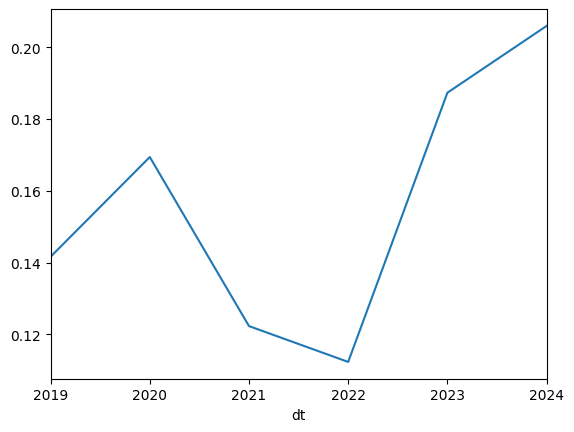

In [131]:
 byy.rolling(window=1, center=False).mean().plot()

<Axes: xlabel='dt'>

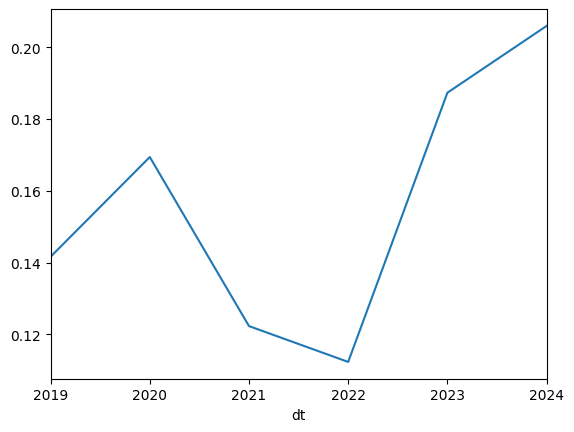

In [118]:
byy.rolling(window=1, center=False).sum().plot()